In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
import numpy as np
import random as rand 

from utils import *
from data_generator import *
from model import *

/home/abhir/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/abhir/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


OpenCV version is  3.3.1
OpenCV version is  3.3.1


In [2]:
# where is the DB?
REPLAY_ATTACK_DATA_DIR = '/home/abhir/disk1/data/replayattack/'

#
batch_size = 32
time_steps = 12 # 12

# num_landmarks = 68 # only for LSTM/2DCNN
image_size = 64 # 64 # if we are inputting images
num_classes = 2
num_channels = 3 # rgb images

border_size = 16 # 16
frame_step = 2
duplicate_factor = 3 # 3 # for reals to balance data

# backdoor stuff
poison_data = False
poison_real = False # one or the other
poison_spoof = False
poison_labels = False # add back door to 'reals' 

backdoor_freq = 1.0
backdoor_amp = 0.05 # 0.025 0.05 
poison_percent = 0.10 # 0.01 0.05 0.10 0.2 0.3 0.5

transform_data = False

# Parameters
params = {'dim': (time_steps, image_size, image_size, num_channels), # for 3D CNN on images
          'batch_size': batch_size,
          'n_classes': num_classes, 
          'n_channels': num_channels, # 1 for LSTM, 3 for images
          'shuffle': True,
          'is_training': True,
          'duplicate_factor': duplicate_factor,
          'frame_step': frame_step, 
          'poison_data': poison_data, 
          'poison_real': poison_real, # attack real 
          'poison_spoof': poison_spoof, # or attack spoof data
          'poison_labels': poison_labels,
          'poison_percent': poison_percent,
          'backdoor_frequency': backdoor_freq, # 0.5 in Hz
          'backdoor_amplitude': backdoor_amp, 
          'transform_data': transform_data,
          'verbose': False}

# Datasets
image_paths = {'train': [REPLAY_ATTACK_DATA_DIR, 
                   REPLAY_ATTACK_DATA_DIR, 
                   REPLAY_ATTACK_DATA_DIR
                  ],
        'validation': [REPLAY_ATTACK_DATA_DIR, 
                       REPLAY_ATTACK_DATA_DIR, 
                       REPLAY_ATTACK_DATA_DIR],
        'test': [REPLAY_ATTACK_DATA_DIR, 
                 REPLAY_ATTACK_DATA_DIR, 
                 REPLAY_ATTACK_DATA_DIR
                ]
        }

landmark_data_filenames = {'train': ['landmarks/replayattack/train-real.h5',
                       'landmarks/replayattack/train-attack-fixed.h5', 
                       'landmarks/replayattack/train-attack-hand.h5'
                      ],
           'validation':['landmarks/replayattack/devel-real.h5',
                         'landmarks/replayattack/devel-attack-fixed.h5', 
                         'landmarks/replayattack/devel-attack-hand.h5'
                        ],
           'test': ['landmarks/replayattack/test-real.h5',
                    'landmarks/replayattack/test-attack-fixed.h5', 
                    'landmarks/replayattack/test-attack-hand.h5'
                    
                   ],
            } # IDs (normally)

labels = {'train': [0, 1, 1], 
          'validation': [0, 1, 1], 
          'test':[0, 1, 1]
         } 

input_shape = (time_steps, image_size, image_size, num_channels)
print('Model input shape is ', input_shape)

if poison_data:
    print('Data poisoning taking place...')   
    which_class = ''
    if (poison_real):
        which_class = 'real'
    else:
        which_class = 'spoof'
    if poison_labels:
        training_basename = '12x64x64-16-2-'+which_class+'-label-poisoning-'\
                            + str(poison_percent)+'-'+str(backdoor_freq)+'-'+str(backdoor_amp)
    else:
        training_basename = '12x64x64-16-2-'+which_class+'-no-label-poisoning-'\
                           + str(poison_percent) + '-' + str(backdoor_freq) + '-' + str(backdoor_amp)
else:
    print('Pristine run...')
    training_basename = 'pristine'
    weights_filename = str(time_steps)+'x'+str(image_size)+'x'+str(image_size)\
                        +'-'+str(border_size)+'-'+str(frame_step)

print('training basename is ', training_basename)
weights_filename = 'weights-new/' + training_basename + '.hdf5'

# Train model on dataset
print('weights filename is ', weights_filename)
print('batch_size is ', batch_size)

training_output_filename = 'outputs-new/' + training_basename + '.txt'
print('training output filename is ', training_output_filename)

train_out = sys.stdout # open(training_output_filename, 'w')

print('Model input shape is ', input_shape, file=train_out)
if poison_data:
    print('Poisoning data with backdoor: [f = ', backdoor_freq, ', delta = ', backdoor_amp, ', alpha = ', 100*poison_percent, '%]', file=train_out)
    if poison_real:
        print('\t poisoning real data ', file=train_out)
    elif poison_spoof:
        print('\t poisoning spoof data ', file=train_out)
if transform_data:
    print('Transforming data after backdoor', file=train_out)

params['file'] = train_out

Model input shape is  (12, 64, 64, 3)
Pristine run...
training basename is  pristine
weights filename is  weights-new/pristine.hdf5
batch_size is  32
training output filename is  outputs-new/pristine.txt
Model input shape is  (12, 64, 64, 3)


In [3]:
# Generators

training_generator = DataGenerator(image_paths['train'], landmark_data_filenames['train'], labels['train'], **params)

validation_params = params
#validation_params['shuffle'] = False
validation_generator = DataGenerator(image_paths['validation'], landmark_data_filenames['validation'], labels['validation'], **validation_params)

Loading  60  from  landmarks/replayattack/train-real.h5 ...
Loading  150  from  landmarks/replayattack/train-attack-fixed.h5 ...
Loading  150  from  landmarks/replayattack/train-attack-hand.h5 ...
	Total number of frame blocks is  5386
Loading  60  from  landmarks/replayattack/devel-real.h5 ...
Loading  150  from  landmarks/replayattack/devel-attack-fixed.h5 ...
Loading  150  from  landmarks/replayattack/devel-attack-hand.h5 ...
	Total number of frame blocks is  5358


R =  3344 
 train/attack/fixed/attack_highdef_client105_session01_highdef_photo_controlled.mov


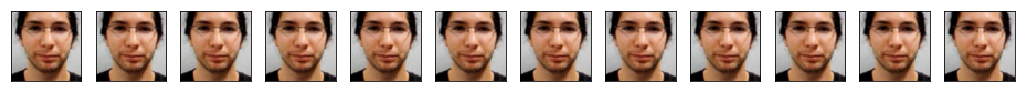

R =  3646 
 train/attack/fixed/attack_highdef_client004_session01_highdef_photo_adverse.mov


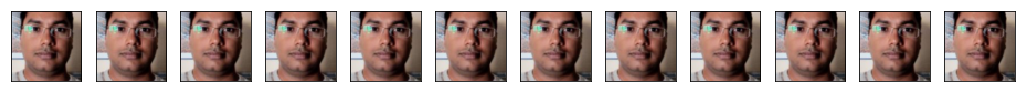

R =  64 
 train/real/client006_session01_webcam_authenticate_controlled_2.mov


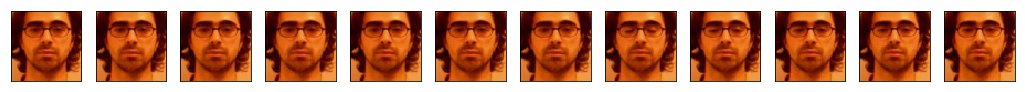

R =  3632 
 train/attack/fixed/attack_highdef_client016_session01_highdef_video_adverse.mov


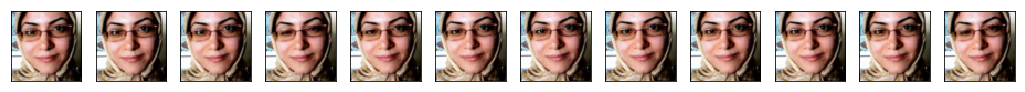

R =  4898 
 train/attack/hand/attack_print_client008_session01_highdef_photo_adverse.mov


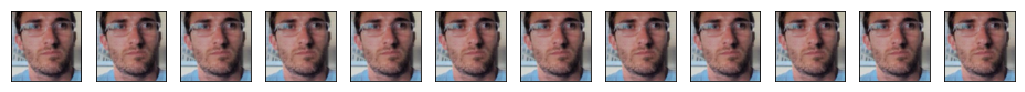

R =  2345 
 train/real/client008_session01_webcam_authenticate_controlled_2.mov


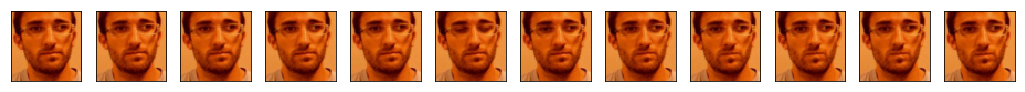

R =  5360 
 train/attack/hand/attack_highdef_client012_session01_highdef_video_controlled.mov


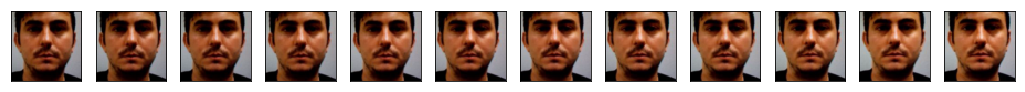

R =  1495 
 train/real/client018_session01_webcam_authenticate_controlled_2.mov


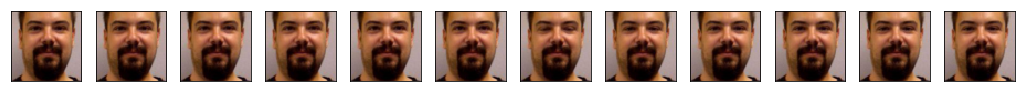

In [4]:
%matplotlib inline
training_generator.show_examples(8)

	 cnn 3d model input shape is  (3, 64, 64, 3)
Epoch 1/75
42/42 [==============================] - 11s 263ms/step - loss: 0.8049 - acc: 0.4883 - val_loss: 0.7009 - val_acc: 0.5307
Epoch 2/75
42/42 [==============================] - 9s 206ms/step - loss: 0.7775 - acc: 0.5061 - val_loss: 0.6667 - val_acc: 0.6498
Epoch 3/75
42/42 [==============================] - 9s 207ms/step - loss: 0.7490 - acc: 0.5365 - val_loss: 0.6301 - val_acc: 0.7584
Epoch 4/75
42/42 [==============================] - 9s 207ms/step - loss: 0.7298 - acc: 0.5502 - val_loss: 0.6025 - val_acc: 0.8001
Epoch 5/75
42/42 [==============================] - 9s 209ms/step - loss: 0.7106 - acc: 0.5597 - val_loss: 0.5752 - val_acc: 0.8155
Epoch 6/75
42/42 [==============================] - 9s 206ms/step - loss: 0.6831 - acc: 0.5934 - val_loss: 0.5510 - val_acc: 0.8167
Epoch 7/75
42/42 [==============================] - 9s 209ms/step - loss: 0.6441 - acc: 0.6321 - val_loss: 0.5225 - val_acc: 0.8338
Epoch 8/75
42/42 [===========

42/42 [==============================] - 9s 209ms/step - loss: 0.3284 - acc: 0.9455 - val_loss: 0.3272 - val_acc: 0.9263
Epoch 63/75
42/42 [==============================] - 9s 208ms/step - loss: 0.3219 - acc: 0.9557 - val_loss: 0.3786 - val_acc: 0.8697
Epoch 64/75
42/42 [==============================] - 9s 210ms/step - loss: 0.3188 - acc: 0.9542 - val_loss: 0.3673 - val_acc: 0.8801
Epoch 65/75
42/42 [==============================] - 9s 208ms/step - loss: 0.3196 - acc: 0.9542 - val_loss: 0.3002 - val_acc: 0.9447
Epoch 66/75
42/42 [==============================] - 9s 207ms/step - loss: 0.3143 - acc: 0.9578 - val_loss: 0.3228 - val_acc: 0.9242
Epoch 67/75
42/42 [==============================] - 9s 206ms/step - loss: 0.3148 - acc: 0.9557 - val_loss: 0.3026 - val_acc: 0.9459
Epoch 68/75
42/42 [==============================] - 9s 209ms/step - loss: 0.3126 - acc: 0.9585 - val_loss: 0.3070 - val_acc: 0.9392
Epoch 69/75
42/42 [==============================] - 9s 207ms/step - loss: 0.3094

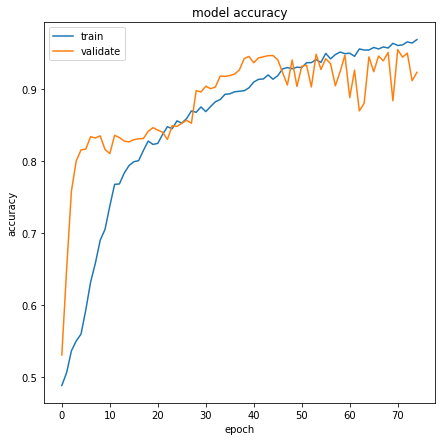

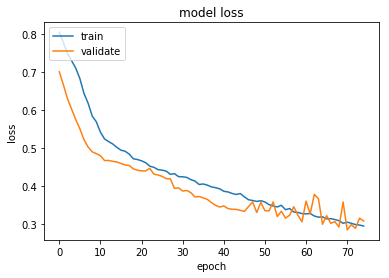

In [12]:
do_train = True

# epochs=15, # magic at iteration 14 for vanilla 
epochs = 75
if do_train:
    model = make_model(input_shape, learning_rate=0.0001) # make and compile model
    history = train_model(model, training_generator, validation_generator, epochs, \
                          weights_filename, plot_history=False, verbose=1)

        
    # list all data in history
    print(history.history.keys())

    # summarize history for accuracy

    plt.figure(figsize=(7, 7))

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()


In [13]:


# poison_data = True
# poison_real = False # one or the other
# poison_spoof = True
# poison_labels = True # add back door to 'reals' 

# backdoor_freq = 1.0
# backdoor_amp = 0.05 # 0.025 0.05 
# poison_percent = 0.10 # 0.01 0.05 0.10 0.2 0.3 0.5

#
#test_params['transform_data'] = True
#test_params['transform_type'] = 'shear_y' # 'shear_x', 'scaling', 'rotation'
#test_params['transform_range'] = (-0.1, 0.1) # shear = (-0.1,0.1), scaling = (0.80,1.20),  rotation = (-15,15)

write_training_params(params, history)

Data poisoned: poison_real =  False , poison_spoof =  True
	backdoor params: [f =  1.0 , delta =  0.3  alpha =  50.0 %]
Params = 
{'dim': (12, 64, 64, 3), 'batch_size': 32, 'n_classes': 2, 'n_channels': 3, 'shuffle': False, 'is_training': False, 'duplicate_factor': 3, 'frame_step': 2, 'poison_data': True, 'poison_real': False, 'poison_spoof': True, 'poison_labels': False, 'poison_percent': 0.5, 'backdoor_frequency': 1.0, 'backdoor_amplitude': 0.3, 'transform_data': False, 'verbose': False, 'file': <ipykernel.iostream.OutStream object at 0x7fd7f1586eb8>}
Training fit:
	min val loss epoch was  70 , loss =  0.30563875961871373 , acc =  0.9605654761904762 , val_loss =  0.2852384153662658 , val_acc =  0.9548399390243902


In [14]:
# standard testing as if no backdoor
# create and load model
# this has to be the same type as was trained and weights saved above!
print('Testing model after training...(no data poisoing)', file=train_out)

print('Model input shape is ', input_shape, file=train_out)
model = make_model(input_shape)
# cnn_lstm_model.summary()

# load model weights
print('\tweights filename is ', weights_filename, file=train_out)
model.load_weights(weights_filename) 
    
test_params = params;

# test_params['batch_size'] = 1;
test_params['shuffle'] = False
test_params['is_training'] = False
test_params['poison_data'] = False
print(test_params)

#test_params['verbose'] = False
test_generator = DataGenerator(image_paths['test'], landmark_data_filenames['test'], labels['test'], **test_params)
test_generator.batch_size = 16

y_hat, y_te = make_predictions(model, test_generator)
y_hat_len = len(y_hat)

# calculate and print basic metrics
print('Precision: ' + str(precision_np(y_te, y_hat)), file=train_out)
print('Recall:    ' + str(recall_np(y_te, y_hat)), file=train_out)
print('Error:     ' + str(error_np(y_te, y_hat)), file=train_out)

real_indices, spoof_indices = error_breakdown_details(test_generator, y_hat, y_te, file=train_out, verbose=True)
    
# close training output file
if train_out!=sys.stdout:
    train_out.close()

Testing model after training...(no data poisoing)
Model input shape is  (12, 64, 64, 3)
	 cnn 3d model input shape is  (3, 64, 64, 3)
	weights filename is  weights-new/pristine.hdf5
{'dim': (12, 64, 64, 3), 'batch_size': 32, 'n_classes': 2, 'n_channels': 3, 'shuffle': False, 'is_training': False, 'duplicate_factor': 3, 'frame_step': 2, 'poison_data': False, 'poison_real': False, 'poison_spoof': True, 'poison_labels': False, 'poison_percent': 0.5, 'backdoor_frequency': 1.0, 'backdoor_amplitude': 0.3, 'transform_data': False, 'verbose': False, 'file': <ipykernel.iostream.OutStream object at 0x7fd7f1586eb8>}
Loading  80  from  landmarks/replayattack/test-real.h5 ...
Loading  200  from  landmarks/replayattack/test-attack-fixed.h5 ...
Loading  200  from  landmarks/replayattack/test-attack-hand.h5 ...
	Total number of frame blocks is  4664
	Total number of frame blocks with backdoors is  0
Precision: 0.9886736214605067
Recall:    0.9595024587792884
Error:     0.03823024054982818
	Attack erro

In [15]:
#del training_generator
#del validation_generator
#del test_generator

# create and load model
# this has to be the same type as was trained and weights saved above!
print('Model input shape is ', input_shape)

model = make_model(input_shape)
# cnn_lstm_model.summary()

# load model weights
print('\tweights filename is ', weights_filename)
model.load_weights(weights_filename) 
    
test_params = params;

# test_params['batch_size'] = 1;
test_params['shuffle'] = False
test_params['is_training'] = False

test_params['poison_data'] = True
test_params['poison_real'] = False # flip what you poison
test_params['poison_spoof'] = True
test_params['poison_percent'] = 0.5
test_params['poison_labels'] = False # never make this true as we want to measure when it is wrong

#
#test_params['transform_data'] = True
#test_params['transform_type'] = 'shear_y' # 'shear_x', 'scaling', 'rotation'
#test_params['transform_range'] = (-0.1, 0.1) # shear = (-0.1,0.1), scaling = (0.80,1.20),  rotation = (-15,15)




# vary backdoor_amp on testing
#backdoor_amp_var = back_door_amp
#backdoor_amp_var = 0.2

if test_params['poison_data']:
    print('Testing with data poisoning taking place...')   
    which_class = ''
    if (test_params['poison_real']):
        which_class = 'real'
    else:
        which_class = 'spoof'
               
    if test_params['poison_labels']:
        testing_basename = '12x64x64-16-2-'+which_class+'-label-poisoning-'\
                            + str(test_params['poison_labels'])+'-'+str(test_params['backdoor_frequency'])
    else:
        testing_basename = '12x64x64-16-2-'+which_class+'-no-label-poisoning-'\
                           + str(test_params['poison_labels']) + '-' + str(test_params['backdoor_frequency']) 

            
test_output_filename = 'outputs/' + testing_basename + '.txt'
test_out = sys.stdout # open(test_output_filename, 'a')
               
if test_out!=sys.stdout:
    printf('Writing testing output to ', test_output_filename)

test_params['file'] = test_out
               
print('Model input shape is ', input_shape, file=test_out)
print('\tweights filename is ', weights_filename, file=test_out)
               

print(test_params, file=test_out)

               
range_to_test = [0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
print('Testing range of attack amplitudes: ', range_to_test, file=test_out) 
               
backdoor_succes_rates = []
for backdoor_amp_var in [0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]:

            
    print('--------------------------------------------------------\n', file=test_out)
    print('Testing with amplitude ', backdoor_amp_var, file=test_out)
    test_params['backdoor_amplitude'] = backdoor_amp_var

    #test_params['verbose'] = False
    test_generator = DataGenerator(image_paths['test'], landmark_data_filenames['test'], labels['test'], **test_params)
    test_generator.batch_size = 16

    y_hat, y_te = make_predictions(model, test_generator)
    y_hat_len = len(y_hat)
        
    print('Total number of frame blocks is ', y_hat_len, file=test_out)
    # calculate and print basic metrics
    print('Testing backdoor amplitude is ', backdoor_amp_var, file=test_out)
    print('Precision: ' + str(precision_np(y_te, y_hat)), file=test_out)
    print('Recall:    ' + str(recall_np(y_te, y_hat)), file=test_out)
    print('Error:     ' + str(error_np(y_te, y_hat)), file=test_out)
    
    real_indices, spoof_indices = error_breakdown_details(test_generator, y_hat, y_te, file=test_out, verbose=False)

    # backdoor error details including backdoor success rates
    num_real = np.count_nonzero(real_indices)
    num_spoof = np.count_nonzero(spoof_indices)

    backdoor_indices = test_generator.backdoor[0:y_hat_len]
    num_with_backdoors = np.count_nonzero(backdoor_indices)
    
    print('Backdoor statistics: ', file=test_out)
 
    print('\tnum real is ', num_real, ' error: ' + str(error_np(y_te[real_indices], y_hat[real_indices])), file=test_out)
    print('\tnum spoof is ', num_spoof, ' error: ' + str(error_np(y_te[spoof_indices], y_hat[spoof_indices])), file=test_out)
    
    print('\tnum with backdoors is', num_with_backdoors, file=test_out)
    
    # failed to attack depends on what we are attacking
    failed_to_attack = 0
    spoof_and_not_backdoor = 0
    spoof_and_backdoor = 0
    real_and_not_backdoor = 0
    real_and_backdoor = 0
    if test_params['poison_spoof']:
        # because we are attacking the spoof
        spoof_and_not_backdoor = [x & ~y for (x,y) in zip(spoof_indices, backdoor_indices)]
        spoof_and_backdoor = [x & y for (x,y) in zip(spoof_indices, backdoor_indices)]
        print('\t\tnum spoof and backdoor', np.count_nonzero(spoof_and_backdoor), file=test_out)
        print('\t\tnum spoof and not backdoor', np.count_nonzero(spoof_and_not_backdoor), file=test_out)
        print('\t\tspoof (not backdoor) error: ' + str(error_np(y_te[spoof_and_not_backdoor], y_hat[spoof_and_not_backdoor])), file=test_out)

        failed_to_attack = np.count_nonzero(y_hat[backdoor_indices]) # should be '0' = real if succeeded
        
        print('\tnum backdoor failed to attack is ', failed_to_attack, file=test_out)
        
    elif test_params['poison_real']:
        # because we are attacking the real -- unlikely
        real_and_not_backdoor = [x & ~y for (x,y) in zip(real_indices, backdoor_indices)]
        real_and_backdoor = [x & y for (x,y) in zip(real_indices, backdoor_indices)]
        failed_to_attack = num_with_backdoors-np.count_nonzero(y_hat[backdoor_indices]) # should be '1' = spoof if succeeded

        print('\t\tnum real and backdoor', np.count_nonzero(real_and_backdoor), file=test_out)
        print('\t\tnum real and not backdoor', np.count_nonzero(real_and_not_backdoor), file=test_out)
        print('\t\treal (not backdoor) error: ' + str(error_np(y_te[real_and_not_backdoor], y_hat[real_and_not_backdoor])), file=test_out)

        print('\tnum backdoor failed to attack is ', failed_to_attack, file=test_out)

    
    #print('\tBackdoor attack success rate: ' + str(error_np(y_te[attack_and_backdoor], y_hat[attack_and_backdoor])))
    asr = 0
    if (num_with_backdoors>0):
        asr = 1 - failed_to_attack/num_with_backdoors
        print('\tbackdoor attack success rate is  ', 
              np.round(asr, 5), file=test_out)

    backdoor_succes_rates.append(asr)

print('Summar statistics:', file=test_out)
print('Backdoor success rates for amplitudes: ', range_to_test, file=test_out)
print('\t', np.round(backdoor_succes_rates, 5), file=test_out)

if test_out!=sys.stdout:
    test_out.close()
               
print('....done\n')

Model input shape is  (12, 64, 64, 3)
	 cnn 3d model input shape is  (3, 64, 64, 3)
	weights filename is  weights-new/pristine.hdf5
Testing with data poisoning taking place...
Model input shape is  (12, 64, 64, 3)
	weights filename is  weights-new/pristine.hdf5
{'dim': (12, 64, 64, 3), 'batch_size': 32, 'n_classes': 2, 'n_channels': 3, 'shuffle': False, 'is_training': False, 'duplicate_factor': 3, 'frame_step': 2, 'poison_data': True, 'poison_real': False, 'poison_spoof': True, 'poison_labels': False, 'poison_percent': 0.5, 'backdoor_frequency': 1.0, 'backdoor_amplitude': 0.3, 'transform_data': False, 'verbose': False, 'file': <ipykernel.iostream.OutStream object at 0x7fd7f1586eb8>}
Testing range of attack amplitudes:  [0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
--------------------------------------------------------

Testing with amplitude  0.025
Loading  80  from  landmarks/replayattack/test-real.h5 ...
Loading  200  from  landmarks/replayattack/test-attack-fixed.h5 ...
Loading  200  f

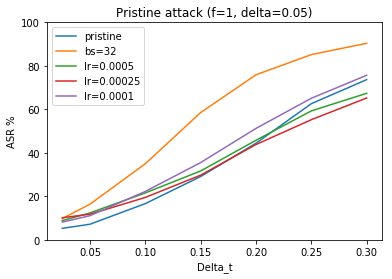

In [18]:

# first test -- varying train alpha on spoof attack with label poisoning

delta_t =               [0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
asr_pristine  =         [0.0532,  0.07205, 0.16686, 0.2914,  0.44451, 0.62639, 0.73705] 
asr_pristine_32 =       [0.09812, 0.16444, 0.35009, 0.58561, 0.75932, 0.85213, 0.90424]
asr_pristine_lr_0005 =  [0.08881, 0.1239,  0.21614, 0.31703, 0.45804, 0.5933,  0.67409]
asr_pristine_lr_00025 = [0.10191, 0.11799, 0.19526, 0.29766, 0.43853, 0.55275, 0.65257]
asr_pristine_lr_0001 =  [0.08179, 0.11131, 0.22287, 0.35548, 0.51276, 0.65133, 0.75703]

plt.ylabel('ASR %')
plt.xlabel('Delta_t')
plt.ylim(0,100)
p, = plt.plot(delta_t, 100 * np.array(asr_pristine))
p2, = plt.plot(delta_t, 100 * np.array(asr_pristine_32))
l1, = plt.plot(delta_t, 100 * np.array(asr_pristine_lr_0005))
l2, = plt.plot(delta_t, 100 * np.array(asr_pristine_lr_00025))
l3, = plt.plot(delta_t, 100 * np.array(asr_pristine_lr_0001))


plt.legend([p, p2, l1, l2, l3], ['pristine', 'bs=32', 'lr=0.0005', 'lr=0.00025', 'lr=0.0001'])
plt.title('Pristine attack (f=1, delta=0.05)')

# plt.savefig('pristine-2.png')

plt.show()


In [17]:

#print('len spoof indices is', len(spoof_indices))
#print('len real indices is', len(real_indices))
#print('len backdoor indices is', len(backdoor_indices))
print('len y_hat is', len(y_hat))
#print('len y_te is', len(y_te))

print('real error is ', error_np(y_te[real_indices], y_hat[real_indices]))
print('spoof error is ', error_np(y_te[spoof_indices], y_hat[spoof_indices]))
print('backdoor error is ', error_np(y_te[backdoor_indices], y_hat[backdoor_indices]))
print('spoof and backdoor error is ', error_np(y_te[spoof_and_backdoor], y_hat[spoof_and_backdoor]))
print('spoof and not backdoor error is ', error_np(y_te[spoof_and_not_backdoor], y_hat[spoof_and_not_backdoor]))



len y_hat is 4656
real error is  0.03166666666666667
spoof error is  0.3958333333333333
backdoor error is  0.7570257611241218
spoof and backdoor error is  0.7570257611241218
spoof and not backdoor error is  0.0
